In [36]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging
import cv2
import os

In [92]:
# Importing the data files

data = pd.read_csv('/Users/miller/VelibMap/data_8am.csv')

data.columns

Index(['Unnamed: 0', 'STATION_ID', 'NUM_DOCKS_AVAILABLE', 'NUM_MECHANICAL',
       'NUM_E_BIKES', 'NAME', 'LAT', 'LON', 'FREQUENCY_AVAILABLE_DOCKS'],
      dtype='object')

### Coordinates transformation

Transforming the 'brute' coordinates to the ones we need to superpose the Vélib stations to the map of Paris

In [93]:
def get_ML_transform():
    """
    Getting the linear relation between the brute coordinates and the ones we extracted from the dotted map of 
    Paris, applying a few dots (4) by hand
    """
    X = np.array([[48.834861, 2.344577], [48.865316, 2.376115], [48.857331, 2.351458], [48.846454, 2.415514]])
    y = np.array([[692, 568], [878, 290], [730, 365], [1114, 458]])

    reg = LinearRegression().fit(X, y)

    reg.predict(np.array([[48.846454, 2.415514]]))

    return reg.predict

predict = get_ML_transform()

new_coordinates = data.apply(lambda row: predict(np.array([[row.LAT, row.LON]]))[0], axis=1)

data[['NEW_LAT', 'NEW_LON']] = new_coordinates.values.tolist()

In [94]:
def show_img(x):
    size = 12
    fig, ax = plt.subplots(figsize=(size, size))
    plt.imshow(x, cmap=plt.cm.gray, interpolation='nearest')
    plt.show()

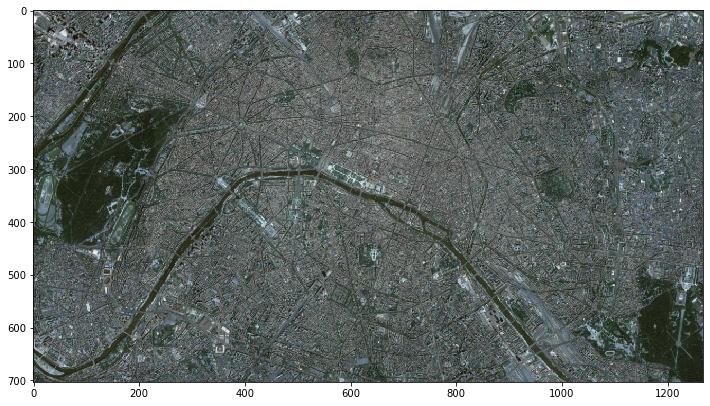

In [95]:
img_path = '/Users/miller/VelibMap/ParisMap.png'
img_dots_path = '/Users/miller/VelibMap/ParisMapDots.png'

img = cv2.imread(img_path)
img_dots = cv2.imread(img_dots_path)

matrix = img_dots[:, :, 0]

show_img(img)

In [96]:
data = data[(data['NEW_LAT'] <= 1200) &
            (data['NEW_LAT'] >= 0) &
            (data['NEW_LON'] <= 700) &
            (data['NEW_LON'] >= 0)] 

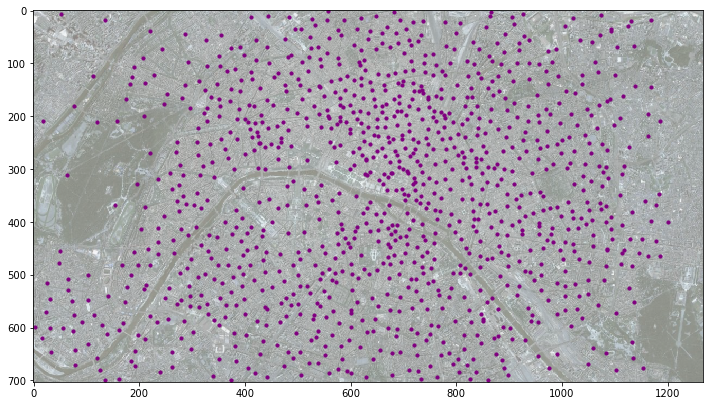

In [97]:
size = 12
fig, ax = plt.subplots(figsize=(size, size))
plt.imshow(img, cmap=plt.cm.gray, interpolation='nearest', origin='upper', alpha=0.5)
plt.scatter(data['NEW_LAT'], data['NEW_LON'], alpha=1, s=10, color='purple')
plt.show()

In [98]:
# Preprocessing the column 'c'
c = 'FREQUENCY_AVAILABLE_DOCKS'
data[c] = data[c].apply(lambda value: 0.01 if value != value else value)

# TODO: Add this in the processing itself
# Adding some columns
data['TOTAL_NUMBER_SLOTS'] = data.apply(lambda row: row.NUM_MECHANICAL + row.NUM_E_BIKES + row.NUM_DOCKS_AVAILABLE, axis=1)

def divide(row, col1, col2):
    if row[col2] != 0:
        return row[col1] / row[col2]
    return 0

data['FREQUENCY_AVAILABLE_M'] = data.apply(lambda row: divide(row, 'NUM_MECHANICAL', 'TOTAL_NUMBER_SLOTS'), axis=1)
data['FREQUENCY_AVAILABLE_E'] = data.apply(lambda row: divide(row, 'NUM_E_BIKES', 'TOTAL_NUMBER_SLOTS'), axis=1)

In [99]:
def transform_alpha(x):
    """
    Mapping [0, 1] to [0, 1] to intensify the alpha on the plots
    """
    return x ** (0.8)

for col in ['FREQUENCY_AVAILABLE_M', 'FREQUENCY_AVAILABLE_E']:
    data[col] = data[col].apply(lambda x: transform_alpha(x))

In [108]:
class PlotResults:
    def __init__(self, data):
        self.data = data
        self.figsize = 8
        
    def plot(self, color=None, alpha=None, title=None, graph_type=None):
        x = self.data['NEW_LAT']
        y = self.data['NEW_LON']
        
        fig, ax = plt.subplots(figsize=(self.figsize, self.figsize))
        plt.imshow(img, cmap=plt.cm.gray, interpolation='nearest', origin='upper', alpha=0.5)
        ax.scatter(x, y, color=color, s=3, alpha=alpha)
        plt.title(title)
        plt.show()
        
    def plot_all_bikes(self, color=None, alpha=None, title=None, graph_type=None):
        x = self.data['NEW_LAT']
        y = self.data['NEW_LON']
        
        fig, ax = plt.subplots(figsize=(self.figsize, self.figsize))
        plt.imshow(img, cmap=plt.cm.gray, interpolation='nearest', origin='upper', alpha=0.5)
        ax.scatter(x, y, color='orange', s=10, alpha=data['FREQUENCY_AVAILABLE_M'], label='Mechanical bikes')
        ax.scatter(x, y, color='purple', s=10, alpha=data['FREQUENCY_AVAILABLE_E'], label='Electrical bikes')
            
        ax.legend()
        plt.title(title)
        plt.show()
    
    def dot_plot(self, color=None, alpha=None, title=None, graph_type=None):
        x = self.data['NEW_LAT']
        y = self.data['NEW_LON']
        
        fig, ax = plt.subplots(figsize=(15, 15))
        plt.imshow(img, cmap=plt.cm.gray, interpolation='nearest', origin='upper', alpha=0.5)
        ax.scatter(x, y, color='purple', s=data['NUM_MECHANICAL'] + data['NUM_E_BIKES'], alpha=1, 
                   label='Number of available bikes')
            
        ax.legend()
        plt.title(title)
        plt.show()
        
    def dot_plot_total_slots(self, color=None, alpha=None, title=None, graph_type=None):
        x = self.data['NEW_LAT']
        y = self.data['NEW_LON']
        
        fig, ax = plt.subplots(figsize=(15, 15))
        plt.imshow(img, cmap=plt.cm.gray, interpolation='nearest', origin='upper', alpha=0.5)
        ax.scatter(x, y, color='purple', s=data['TOTAL_NUMBER_SLOTS'] / 2, alpha=1, 
                   label='Total number of slots by station')
            
        ax.legend()
        plt.title(title)
        plt.show()
        
    def dot_plot_available_slots(self, color=None, alpha=None, title=None, graph_type=None):
        x = self.data['NEW_LAT']
        y = self.data['NEW_LON']
        
        fig, ax = plt.subplots(figsize=(15, 15))
        plt.imshow(img, cmap=plt.cm.gray, interpolation='nearest', origin='upper', alpha=0.5)
        ax.scatter(x, y, color='purple', s=data['NUM_DOCKS_AVAILABLE'], alpha=1, 
                   label='Total number of available slots by station')
            
        ax.legend()
        plt.title(title)
        plt.show()
        
    def _plot_available_docks(self, graph_type=None):
        self._plot(alpha=data['FREQUENCY_AVAILABLE_DOCKS'], graph_type=graph_type)
                
    def _plot_available_m(self, graph_type=None):
        self._plot(alpha=data['FREQUENCY_AVAILABLE_M'], graph_type=graph_type)
                
    def _plot_available_e(self, graph_type=None):
        self._plot(alpha=data['FREQUENCY_AVAILABLE_E'], graph_type=graph_type)

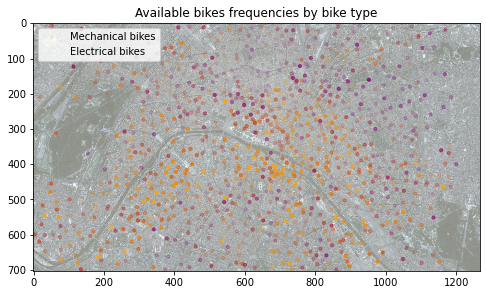

In [109]:
PlotResults(data).plot_all_bikes(title='Available bikes frequencies by bike type')

In [110]:
data.columns

Index(['Unnamed: 0', 'STATION_ID', 'NUM_DOCKS_AVAILABLE', 'NUM_MECHANICAL',
       'NUM_E_BIKES', 'NAME', 'LAT', 'LON', 'FREQUENCY_AVAILABLE_DOCKS',
       'NEW_LAT', 'NEW_LON', 'TOTAL_NUMBER_SLOTS', 'FREQUENCY_AVAILABLE_M',
       'FREQUENCY_AVAILABLE_E'],
      dtype='object')

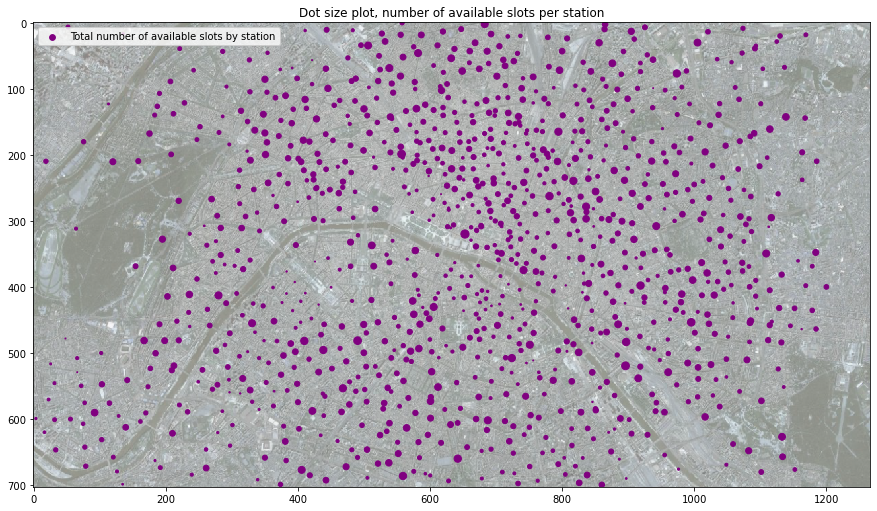

In [111]:
PlotResults(data).dot_plot_available_slots(title='Dot size plot, number of available slots per station')

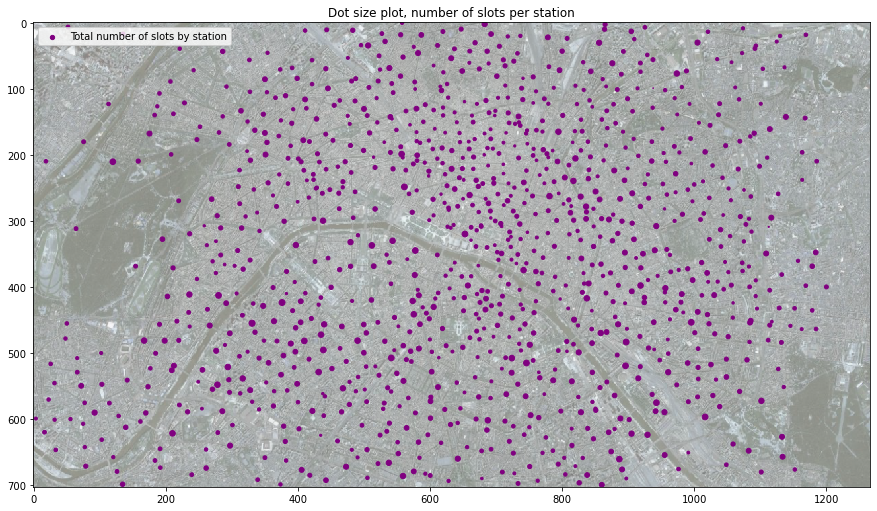

In [105]:
PlotResults(data).dot_plot_total_slots(title='Dot size plot, number of slots per station')

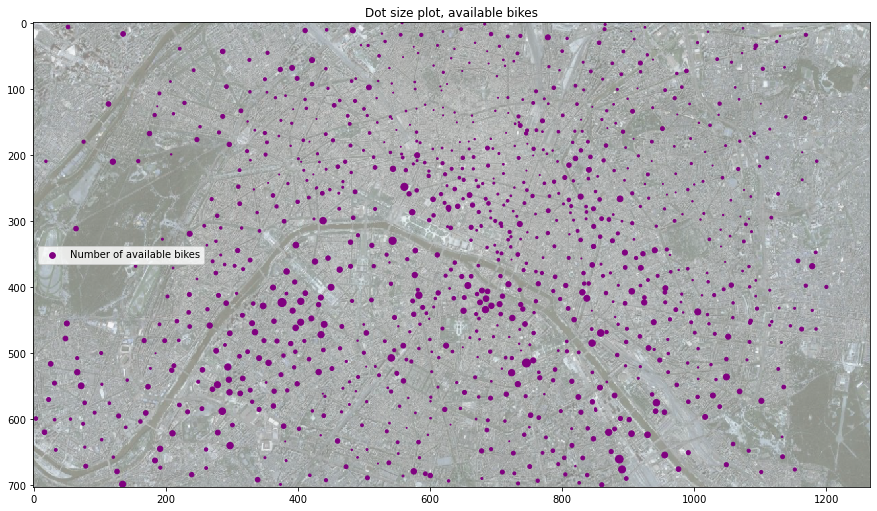

In [106]:
PlotResults(data).dot_plot(title='Dot size plot, available bikes')

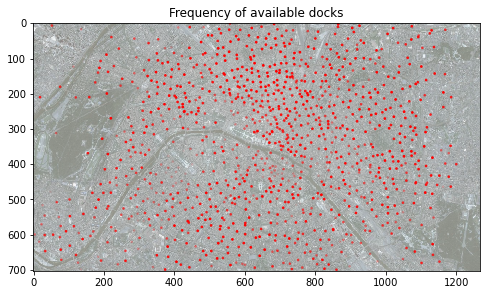

In [107]:
PlotResults(data).plot(alpha=data['FREQUENCY_AVAILABLE_DOCKS'],
                       color='red',
                       title='Frequency of available docks')

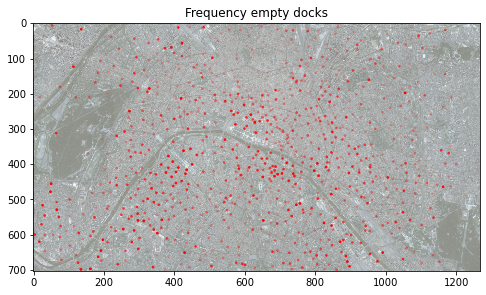

In [56]:
PlotResults(data).plot(alpha=1 - data['FREQUENCY_AVAILABLE_DOCKS'],
                       color='red',
                       title='Frequency empty docks')

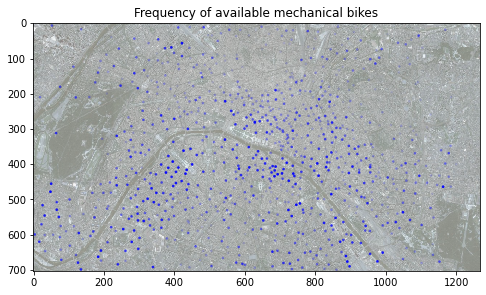

In [49]:
PlotResults(data).plot(alpha=data['FREQUENCY_AVAILABLE_M'],
                       color='blue',
                       title='Frequency of available mechanical bikes')

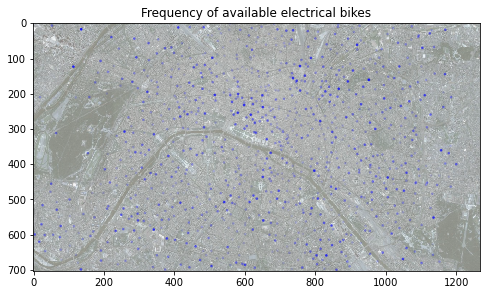

In [50]:
PlotResults(data).plot(alpha=data['FREQUENCY_AVAILABLE_E'],
                       color='blue',
                       title='Frequency of available electrical bikes')